In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)

import pandas as pd
import numpy as np

In [2]:
## Player of week
POTW = pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv')
POTW = POTW.loc[POTW['Season short'] > 1990]
POTW.tail(10)

,Active season,Player,Team,Conference,Date,Position,Height,Weight,Age,Draft Year,Seasons in league,Season,Season short,Real_value
1177,1,Nikola Vucevic,Orlando Magic,East,"Nov 19, 2018",PF,7-0,260,28,2011,7,2018-2019,2019,0.5
1178,1,Anthony Davis,New Orleans Pelicans,West,"Nov 19, 2018",PF,6-10,253,25,2012,6,2018-2019,2019,0.5
1179,1,Pascal Siakam,Toronto Raptors,East,"Nov 12, 2018",F,6-9,230,25,2016,2,2018-2019,2019,0.5
1180,1,C.J. McCollum,Portland Trail Blazers,West,"Nov 12, 2018",G,6-3,190,27,2013,5,2018-2019,2019,0.5
1181,1,Victor Oladipo,Indiana Pacers,East,"Nov 5, 2018",G,6-4,210,26,2013,5,2018-2019,2019,0.5
1182,1,Russell Westbrook,Oklahoma City Thunder,West,"Nov 5, 2018",G,6-3,200,30,2008,10,2018-2019,2019,0.5
1183,1,Giannis Antetokounmpo,Milwaukee Bucks,East,"Oct 29, 2018",F,6-11,242,24,2013,5,2018-2019,2019,0.5
1184,1,Stephen Curry,Golden State Warriors,West,"Oct 29, 2018",G,6-3,190,30,2009,9,2018-2019,2019,0.5
1185,1,Kemba Walker,Charlotte Hornets,East,"Oct 22, 2018",G,6-1,184,28,2011,7,2018-2019,2019,0.5
1186,1,Nikola Jokic,Denver Nuggets,West,"Oct 22, 2018",C,7-0,250,24,2014,3,2018-2019,2019,0.5


In [3]:
## Summary
SUM = pd.read_csv('../data/scraped/NBA_Yearly_Summary.csv')
SUM.tail(15)

,Year,League Champion,Most Valuable Player,Rookie of the Year,PPG Leader,RPG Leader,APG Leader,WS Leader
20,2005,San Antonio Spurs,Steve Nash,Emeka Okafor,Allen Iverson,Kevin Garnett,Steve Nash,Kevin Garnett
21,2006,Miami Heat,Steve Nash,Chris Paul,Kobe Bryant,Kevin Garnett,Steve Nash,Dirk Nowitzki
22,2007,San Antonio Spurs,Dirk Nowitzki,Brandon Roy,Kobe Bryant,Kevin Garnett,Steve Nash,Dirk Nowitzki
23,2008,Boston Celtics,Kobe Bryant,Kevin Durant,LeBron James,Dwight Howard,Chris Paul,Chris Paul
24,2009,Los Angeles Lakers,LeBron James,Derrick Rose,Dwyane Wade,Dwight Howard,Chris Paul,LeBron James
25,2010,Los Angeles Lakers,LeBron James,Tyreke Evans,Kevin Durant,Dwight Howard,Steve Nash,LeBron James
26,2011,Dallas Mavericks,Derrick Rose,Blake Griffin,Kevin Durant,Kevin Love,Steve Nash,LeBron James
27,2012,Miami Heat,LeBron James,Kyrie Irving,Kevin Durant,Dwight Howard,Rajon Rondo,LeBron James
28,2013,Miami Heat,LeBron James,Damian Lillard,Carmelo Anthony,Dwight Howard,Rajon Rondo,LeBron James
29,2014,San Antonio Spurs,Kevin Durant,Michael Carter-Williams,Kevin Durant,DeAndre Jordan,Chris Paul,Kevin Durant


In [4]:
# Person who get most times POTW each year
POTW_count = POTW.groupby(['Season short','Player','Team']).count()['Date'].reset_index().rename(columns = {'Date': 'POTW_Count'})
max_count = POTW_count.groupby('Season short').max()[['POTW_Count']].reset_index().rename(columns = {'POTW_Count': 'Max'})
potw_max = pd.merge(max_count, POTW_count, on = ['Season short'])
potw_max = potw_max.loc[potw_max.Max == potw_max.POTW_Count].drop(columns = 'POTW_Count')
potw_max.tail()

,Season short,Max,Player,Team
628,2017,4,LeBron James,Cleveland Cavaliers
631,2017,4,Russell Westbrook,Oklahoma City Thunder
639,2018,5,DeMar DeRozan,Toronto Raptors
643,2018,5,James Harden,Houston Rockets
665,2019,6,Giannis Antetokounmpo,Milwaukee Bucks


In [5]:
# Join Tables
potw_title = pd.merge(potw_max,SUM, left_on = 'Season short', right_on= 'Year',how = 'left').drop(columns = 'Season short')
potw_title

,Max,Player,Team,Year,League Champion,Most Valuable Player,Rookie of the Year,PPG Leader,RPG Leader,APG Leader,WS Leader
0,3,Clyde Drexler,Portland Trail Blazers,1991,Chicago Bulls,Michael Jordan,Derrick Coleman,Michael Jordan,David Robinson,John Stockton,Michael Jordan
1,2,Karl Malone,Utah Jazz,1992,Chicago Bulls,Michael Jordan,Larry Johnson,Michael Jordan,Dennis Rodman,John Stockton,Michael Jordan
2,2,Tim Hardaway,Golden State Warriors,1992,Chicago Bulls,Michael Jordan,Larry Johnson,Michael Jordan,Dennis Rodman,John Stockton,Michael Jordan
3,3,Hakeem Olajuwon,Houston Rockets,1993,Chicago Bulls,Charles Barkley,Shaquille O'Neal,Michael Jordan,Dennis Rodman,John Stockton,Michael Jordan
4,3,Patrick Ewing,New York Knicks,1993,Chicago Bulls,Charles Barkley,Shaquille O'Neal,Michael Jordan,Dennis Rodman,John Stockton,Michael Jordan
...,...,...,...,...,...,...,...,...,...,...,...
60,4,LeBron James,Cleveland Cavaliers,2017,Golden State Warriors,Russell Westbrook,Malcolm Brogdon,Russell Westbrook,Hassan Whiteside,James Harden,James Harden
61,4,Russell Westbrook,Oklahoma City Thunder,2017,Golden State Warriors,Russell Westbrook,Malcolm Brogdon,Russell Westbrook,Hassan Whiteside,James Harden,James Harden
62,5,DeMar DeRozan,Toronto Raptors,2018,Golden State Warriors,James Harden,Ben Simmons,James Harden,Andre Drummond,Russell Westbrook,James Harden
63,5,James Harden,Houston Rockets,2018,Golden State Warriors,James Harden,Ben Simmons,James Harden,Andre Drummond,Russell Westbrook,James Harden


In [6]:
# function to confirm whether the player got other titles
def confirm(df, column1, column2):
    df.loc[df[column1] != df[column2], column2] = 0
    df.loc[df[column1] == df[column2], column2] = 1 
    return df

In [7]:
# Whether the person who got most time player of the week also got other titles?
for col in potw_title.columns[-6:]:
    potw_title = confirm(potw_title,'Player',str(col))

potw_title

,Max,Player,Team,Year,League Champion,Most Valuable Player,Rookie of the Year,PPG Leader,RPG Leader,APG Leader,WS Leader
0,3,Clyde Drexler,Portland Trail Blazers,1991,Chicago Bulls,0,0,0,0,0,0
1,2,Karl Malone,Utah Jazz,1992,Chicago Bulls,0,0,0,0,0,0
2,2,Tim Hardaway,Golden State Warriors,1992,Chicago Bulls,0,0,0,0,0,0
3,3,Hakeem Olajuwon,Houston Rockets,1993,Chicago Bulls,0,0,0,0,0,0
4,3,Patrick Ewing,New York Knicks,1993,Chicago Bulls,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
60,4,LeBron James,Cleveland Cavaliers,2017,Golden State Warriors,0,0,0,0,0,0
61,4,Russell Westbrook,Oklahoma City Thunder,2017,Golden State Warriors,1,0,1,0,0,0
62,5,DeMar DeRozan,Toronto Raptors,2018,Golden State Warriors,0,0,0,0,0,0
63,5,James Harden,Houston Rockets,2018,Golden State Warriors,1,0,1,0,0,1


In [8]:
# Get Dummy Variables
cols = potw_title.columns[-6:]
potw_title['Neither'] = potw_title[cols].sum(axis=1)
potw_title.loc[potw_title['Neither'] != 0, 'Neither'] = 'either'
potw_title.loc[potw_title['Neither'] == 0, 'Neither'] = 'neither'
potw_title.loc[potw_title['Neither'] == 'neither', 'Neither'] = 1
potw_title.loc[potw_title['Neither'] == 'either', 'Neither'] = 0
potw_title

,Max,Player,Team,Year,League Champion,Most Valuable Player,Rookie of the Year,PPG Leader,RPG Leader,APG Leader,WS Leader,Neither
0,3,Clyde Drexler,Portland Trail Blazers,1991,Chicago Bulls,0,0,0,0,0,0,1
1,2,Karl Malone,Utah Jazz,1992,Chicago Bulls,0,0,0,0,0,0,1
2,2,Tim Hardaway,Golden State Warriors,1992,Chicago Bulls,0,0,0,0,0,0,1
3,3,Hakeem Olajuwon,Houston Rockets,1993,Chicago Bulls,0,0,0,0,0,0,1
4,3,Patrick Ewing,New York Knicks,1993,Chicago Bulls,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60,4,LeBron James,Cleveland Cavaliers,2017,Golden State Warriors,0,0,0,0,0,0,1
61,4,Russell Westbrook,Oklahoma City Thunder,2017,Golden State Warriors,1,0,1,0,0,0,0
62,5,DeMar DeRozan,Toronto Raptors,2018,Golden State Warriors,0,0,0,0,0,0,1
63,5,James Harden,Houston Rockets,2018,Golden State Warriors,1,0,1,0,0,1,0


In [9]:
# Restructure the Table and Rename the columns
potw_title_new = (potw_title.groupby(['Year','Player','Team','Max'])
                  .sum().stack().reset_index())
potw_title_new.columns = ['Year','Player','Team','POTW_Times','Title','Whether']
# Get the Rows Where dummy varibles are 1
potw_title_new = potw_title_new.loc[potw_title_new.Whether == 1]
potw_title_new.head()

,Year,Player,Team,POTW_Times,Title,Whether
6,1991,Clyde Drexler,Portland Trail Blazers,3,Neither,1
13,1992,Karl Malone,Utah Jazz,2,Neither,1
20,1992,Tim Hardaway,Golden State Warriors,2,Neither,1
27,1993,Hakeem Olajuwon,Houston Rockets,3,Neither,1
34,1993,Patrick Ewing,New York Knicks,3,Neither,1


In [10]:
# Set Categorical Variables and thus give the order to the titles
title = ['Most Valuable Player','PPG Leader','WS Leader','RPG Leader','APG Leader','Rookie of the Year','Neither']
potw_title_new.Title = potw_title_new.Title.astype(pd.api.types.CategoricalDtype(categories = title, ordered = True), )
potw_title_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 6 to 448
Data columns (total 6 columns):
Year          89 non-null int64
Player        89 non-null object
Team          89 non-null object
POTW_Times    89 non-null int64
Title         89 non-null category
Whether       89 non-null int64
dtypes: category(1), int64(3), object(2)
memory usage: 4.6+ KB


In [15]:
# Drop the column Neither As there would be overlapped labels and hard for visualization
potw_title_2 = potw_title_new.loc[potw_title_new.Title != 'Neither']

In [16]:
%R -i potw_title_new
%R -i potw_title_2

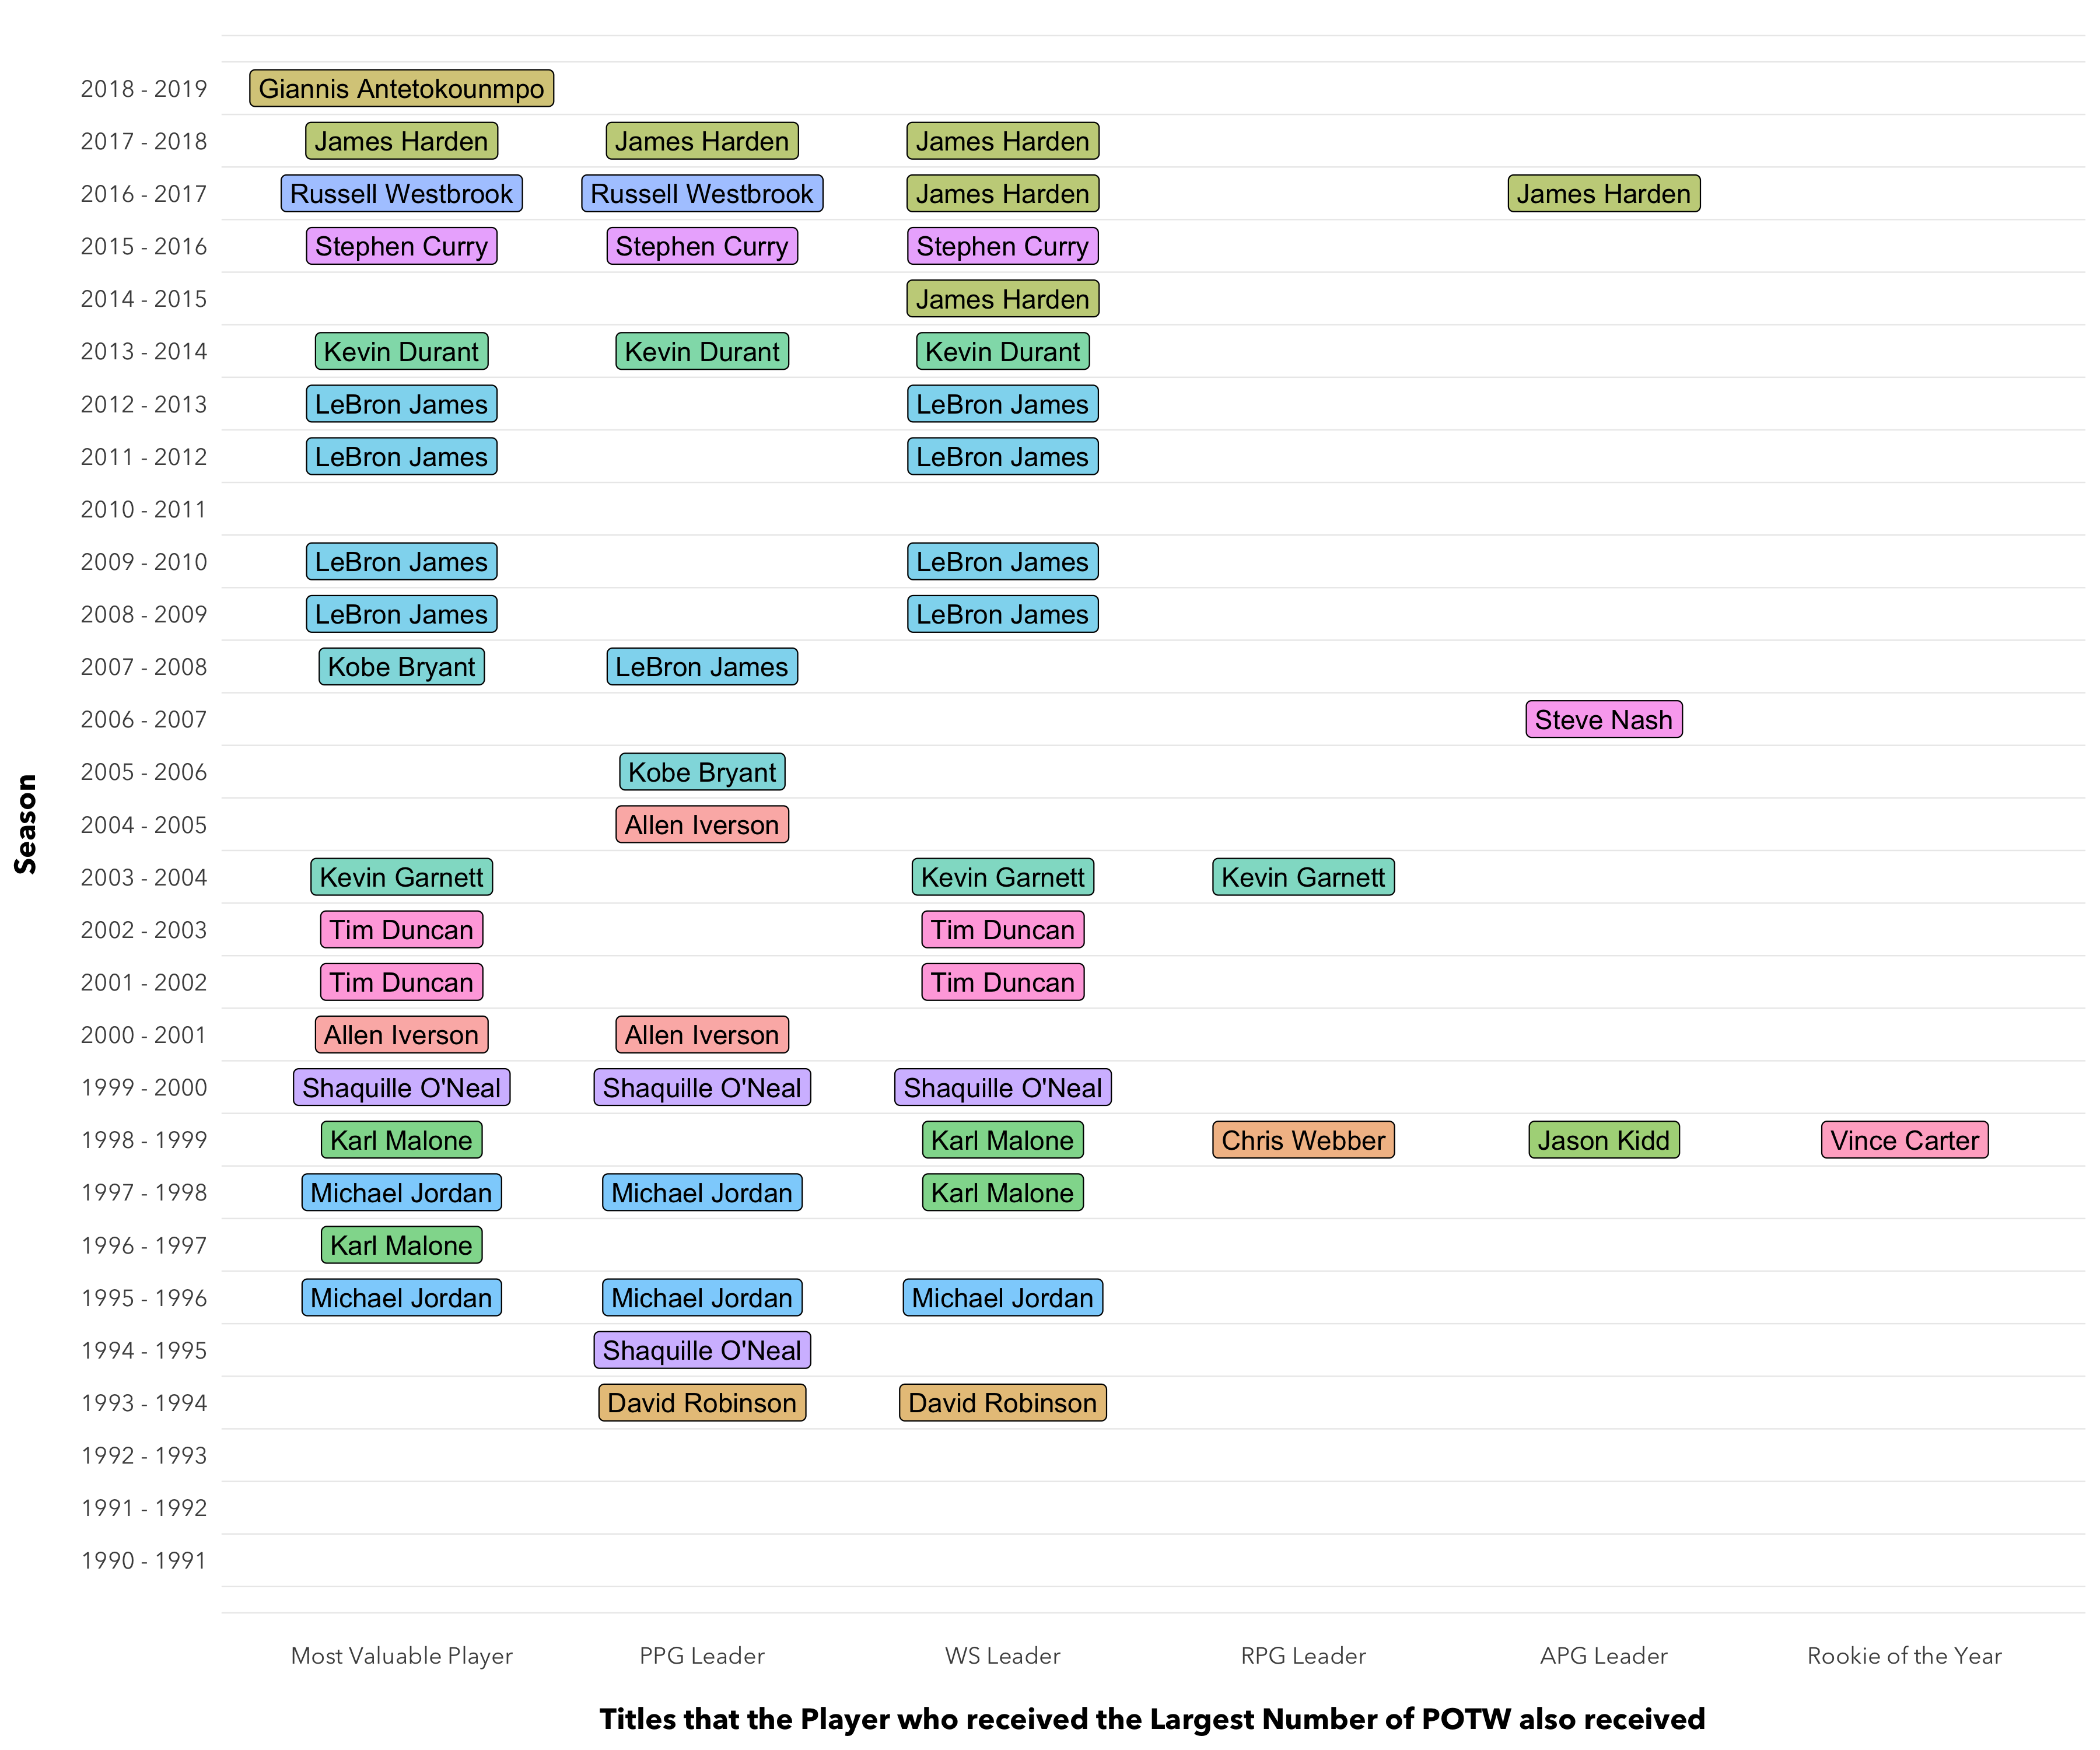

In [17]:
%%R -w 12 -h 10 --units in -r 300
season <- function(x) {
    paste(x - 1, '-', x)
}
ggplot(data = potw_title_2) + 
# geom_point(aes(x = Year, y = Title)) + 
geom_label(aes(x = Year, y = Title, label = Player, fill = Player, alpha = 0.5)) +
guides(fill = F, alpha = F) +
coord_flip() +
theme_minimal(base_size = 12) +
ylab('\nTitles that the Player who received the Largest Number of POTW also received')+
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      panel.grid.major = element_blank(),
      ) +
scale_x_continuous(name = 'Season\n', limits = c(1991, 2019), breaks = seq(1991, 2019, by = 1), label = season)